In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from plot import plot_learning_perturbation, plot_learning
import matplotlib.pyplot as plt

#%matplotlib qt
#%matplotlib widget
%matplotlib inline


fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20
save_fig = '/Users/mahdiyar/Diedrichsenlab Dropbox/Mahdiyar Shahbazi/Conferences/NCM2024_Mahdiyar/figures'


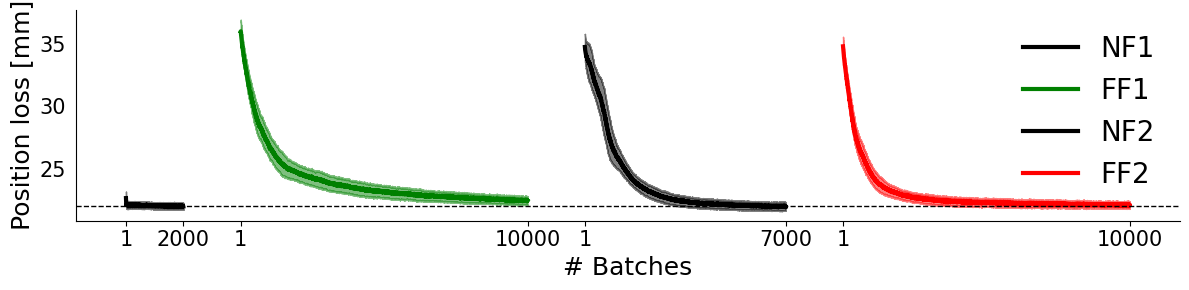

In [2]:
#phase = {'NF2':[0]}
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}

folder_name = 'Sim_all_128'
loss_type = 'position'
ignore = []

fig, ax = plot_learning(folder_name,num_model=20,w=1,phases=phase,loss_type=loss_type,figsize=(12,3),ignore=ignore,show_saving=False)


ax[0].set_xlabel('# Batches', fontsize = fontsize_label)
ax[0].set_ylabel('Position loss [mm]', fontsize = fontsize_label)
ax[0].legend(title = '',frameon = False, bbox_to_anchor= (1,1), fontsize=fontsize_legend)
ax[0].xaxis.set_tick_params(labelsize=fontsize_tick)
ax[0].yaxis.set_tick_params(labelsize=fontsize_tick)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
plt.tick_params(left = False) 




plt.tight_layout()
plt.show()

fig.savefig(os.path.join(save_fig,'bahav_saving.pdf'),dpi=300,bbox_inches='tight')

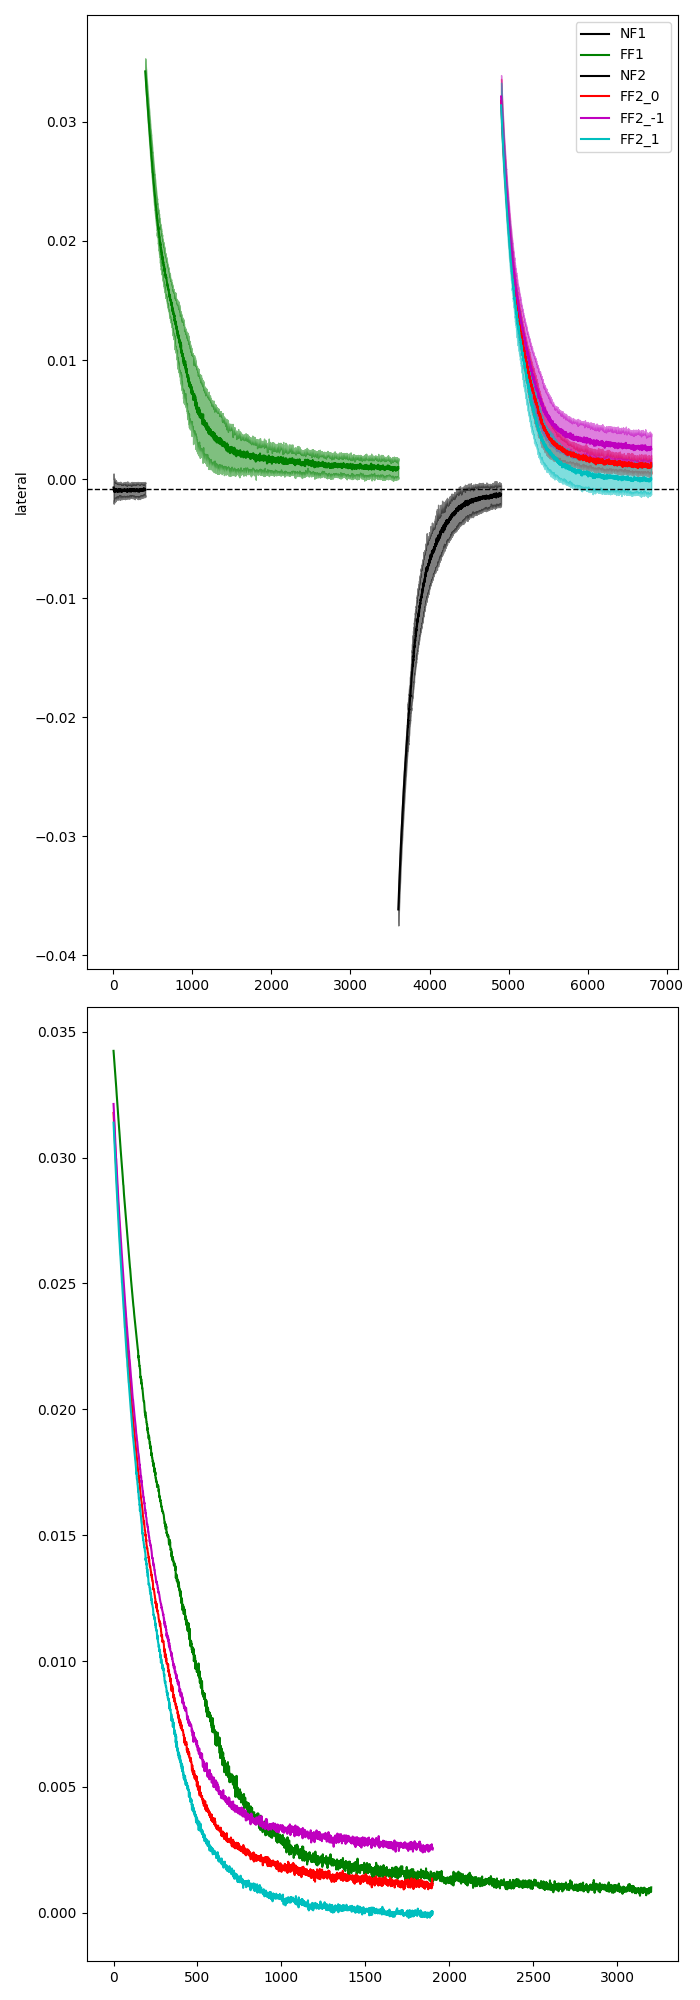

In [ ]:
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
folder_name = 'Sim_simple2'

#%matplotlib widget

fig, ax = plot_learning_perturbation(folder_name,num_model=20,w=1,phases=phase,loss_type='lateral',figsize=(7,20),ignore=[],show_saving=True)
plt.tight_layout()
plt.show()